In [18]:
import time
import aiohttp
import urllib.parse
from IPython.display import Image, display

In [12]:
subscriptionKey = "tTk1JVEaeNvDkxxnxHm9cYaCvqlOq1u-fXTvyXn2XkA"
currentLocation = [34.028115,-118.5184279]
session = aiohttp.ClientSession()

# Parameters for the vehicle consumption model 
travelMode = "car"
vehicleEngineType = "electric"
currentChargeInkWh=45
maxChargeInkWh=80
timeBudgetInSec=550
routeType="eco"
constantSpeedConsumptionInkWhPerHundredkm="50,8.2:130,21.3"


# Get bounds for the electric vehicle's reachable range.
routeRangeResponse = await (await session.get("https://atlas.microsoft.com/route/range/json?subscription-key={}&api-version=1.0&query={}&travelMode={}&vehicleEngineType={}&currentChargeInkWh={}&maxChargeInkWh={}&timeBudgetInSec={}&routeType={}&constantSpeedConsumptionInkWhPerHundredkm={}"
                                              .format(subscriptionKey,str(currentLocation[0])+","+str(currentLocation[1]),travelMode, vehicleEngineType, currentChargeInkWh, maxChargeInkWh, timeBudgetInSec, routeType, constantSpeedConsumptionInkWhPerHundredkm))).json()

polyBounds = routeRangeResponse["reachableRange"]["boundary"]

for i in range(len(polyBounds)):
    coordList = list(polyBounds[i].values())
    coordList[0], coordList[1] = coordList[1], coordList[0]
    polyBounds[i] = coordList

polyBounds.pop()
polyBounds.append(polyBounds[0])

boundsData = {
               "geometry": {
                 "type": "Polygon",
                 "coordinates": 
                   [
                      polyBounds
                   ]
                }
             }

In [13]:
# Search for EV stations within reachable range.
searchPolyResponse = await (await session.post(url = "https://atlas.microsoft.com/search/geometry/json?subscription-key={}&api-version=1.0&query=electric vehicle station&idxSet=POI&limit=50".format(subscriptionKey), json = boundsData)).json() 

reachableLocations = []
for loc in range(len(searchPolyResponse["results"])):
                location = list(searchPolyResponse["results"][loc]["position"].values())
                location[0], location[1] = location[1], location[0]
                reachableLocations.append(location)

In [14]:
rangeData = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          polyBounds
        ]
      }
    }
  ]
}

# Upload range data to Azure Maps data service.
uploadRangeResponse = await session.post("https://atlas.microsoft.com/mapData/upload?subscription-key={}&api-version=1.0&dataFormat=geojson".format(subscriptionKey), json = rangeData)

rangeUdidRequest = uploadRangeResponse.headers["Location"]+"&subscription-key={}".format(subscriptionKey)

while True:
    getRangeUdid = await (await session.get(rangeUdidRequest)).json()
    if 'udid' in getRangeUdid:
        break
    else:
        time.sleep(0.2)
rangeUdid = getRangeUdid["udid"]

In [15]:
poiData = {
    "type": "FeatureCollection",
    "features": [
      {
        "type": "Feature",
        "properties": {},
        "geometry": {
            "type": "MultiPoint",
            "coordinates": reachableLocations
        }
    }
  ]
}

# Upload EV charging stations data to Azure Maps data service.
uploadPOIsResponse = await session.post("https://atlas.microsoft.com/mapData/upload?subscription-key={}&api-version=1.0&dataFormat=geojson".format(subscriptionKey), json = poiData)

poiUdidRequest = uploadPOIsResponse.headers["Location"]+"&subscription-key={}".format(subscriptionKey)

while True:
    getPoiUdid = await (await session.get(poiUdidRequest)).json()
    if 'udid' in getPoiUdid:
        break
    else:
        time.sleep(0.2)
poiUdid = getPoiUdid["udid"]

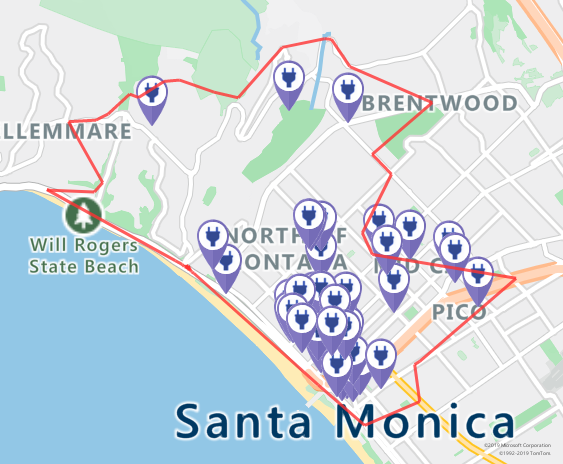

In [16]:
# Get bounds for bounding box.
def getBounds(polyBounds):
    maxLon = max(map(lambda x: x[0], polyBounds))
    minLon = min(map(lambda x: x[0], polyBounds))

    maxLat = max(map(lambda x: x[1], polyBounds))
    minLat = min(map(lambda x: x[1], polyBounds))
    
    # Buffer the bounding box by 10% to account for the pixel size of pins at the ends of the route.
    lonBuffer = (maxLon-minLon)*0.1
    minLon -= lonBuffer
    maxLon += lonBuffer

    latBuffer = (maxLat-minLat)*0.1
    minLat -= latBuffer
    maxLat += latBuffer
    
    return [minLon, maxLon, minLat, maxLat]

minLon, maxLon, minLat, maxLat = getBounds(polyBounds)

path = "lcff3333|lw3|la0.80|fa0.35||udid-{}".format(rangeUdid)
pins = "custom|an15 53||udid-{}||https://raw.githubusercontent.com/Azure-Samples/AzureMapsCodeSamples/master/AzureMapsCodeSamples/Common/images/icons/ev_pin.png".format(poiUdid)

encodedPins = urllib.parse.quote(pins, safe='')

# Render range and EV charging points on the map.
staticMapResponse =  await session.get("https://atlas.microsoft.com/map/static/png?api-version=1.0&subscription-key={}&pins={}&path={}&bbox={}&zoom=12".format(subscriptionKey,encodedPins,path,str(minLon)+", "+str(minLat)+", "+str(maxLon)+", "+str(maxLat)))

poiRangeMap = await staticMapResponse.content.read()

display(Image(poiRangeMap))

In [17]:
for j in range(50):
    locationData = {
                "origins": {
                  "type": "MultiPoint",
                  "coordinates": [[currentLocation[1],currentLocation[0]]]
                },
                "destinations": {
                  "type": "MultiPoint",
                  "coordinates": reachableLocations
                }
             }


    # Get the travel time and distance to every given charging station location.
    searchPolyRes = await (await session.post(url = "https://atlas.microsoft.com/route/matrix/json?subscription-key={}&api-version=1.0&routeType=shortest&waitForResults=true".format(subscriptionKey), json = locationData)).json()

    distances = []

    for dist in range(len(reachableLocations)):
        distances.append(searchPolyRes["matrix"][0][dist]["response"]["routeSummary"]["travelTimeInSeconds"])

    minDistLoc = []

    minDistIndex = distances.index(min(distances))
    minDistLoc.extend([reachableLocations[minDistIndex][1], reachableLocations[minDistIndex][0]])
    closestChargeLoc = ",".join(str(i) for i in minDistLoc)

In [8]:
# Get route from current location to the closest charging station. 
routeResponse = await (await session.get("https://atlas.microsoft.com/route/directions/json?subscription-key={}&api-version=1.0&query={}:{}".format(subscriptionKey, str(currentLocation[0])+","+str(currentLocation[1]), closestChargeLoc))).json()

route = []
for loc in range(len(routeResponse["routes"][0]["legs"][0]["points"])):
                location = list(routeResponse["routes"][0]["legs"][0]["points"][loc].values())
                location[0], location[1] = location[1], location[0]
                route.append(location)

routeData = {
         "type": "LineString",
         "coordinates": route
     }

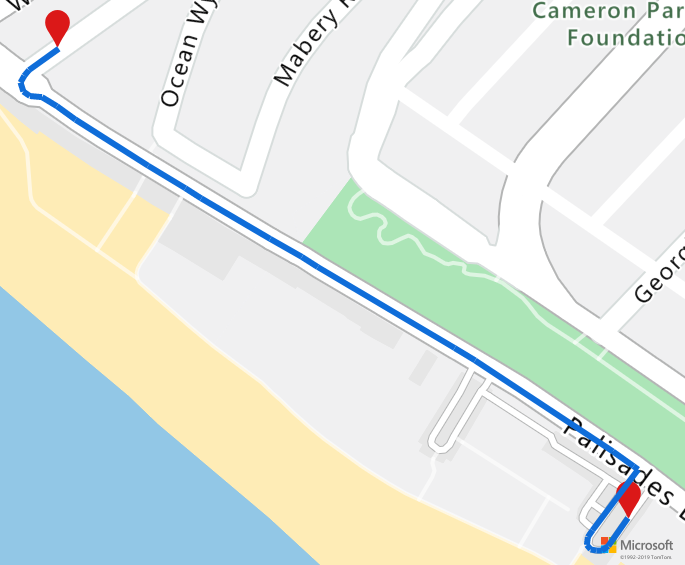

In [9]:
# Upload route data to Azure data service.
routeUploadRequest = await session.post("https://atlas.microsoft.com/mapData/upload?subscription-key={}&api-version=1.0&dataFormat=geojson".format(subscriptionKey), json = routeData)

udidRequestURI = routeUploadRequest.headers["Location"]+"&subscription-key={}".format(subscriptionKey)

while True:
    udidRequest = await (await session.get(udidRequestURI)).json()
    if 'udid' in udidRequest:
        break
    else:
        time.sleep(0.2)

udid = udidRequest["udid"]

destination = route[-1]

destination[1], destination[0] = destination[0], destination[1]

path = "lc0f6dd9|lw6||udid-{}".format(udid)
pins = "default|codb1818||{} {}|{} {}".format(str(currentLocation[1]),str(currentLocation[0]),destination[1],destination[0])


# Get bounds for bounding box.
minLat, maxLat = (float(destination[0]),currentLocation[0]) if float(destination[0])<currentLocation[0] else (currentLocation[0], float(destination[0]))
minLon, maxLon = (float(destination[1]),currentLocation[1]) if float(destination[1])<currentLocation[1] else (currentLocation[1], float(destination[1]))

#Buffer the bounding box by 10% to account for the pixel size of pins at the ends of the route.
lonBuffer = (maxLon-minLon)*0.1
minLon -= lonBuffer
maxLon += lonBuffer

latBuffer = (maxLat-minLat)*0.1
minLat -= latBuffer
maxLat += latBuffer

# Render route on the map.
staticMapResponse = await session.get("https://atlas.microsoft.com/map/static/png?api-version=1.0&subscription-key={}&&path={}&pins={}&bbox={}&zoom=16".format(subscriptionKey,path,pins,str(minLon)+", "+str(minLat)+", "+str(maxLon)+", "+str(maxLat)))

staticMapImage = await staticMapResponse.content.read()

await session.close()
display(Image(staticMapImage))